In [36]:
!pip install fredapi > /dev/null

In [37]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('ggplot')

import fredapi

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("fred-api")

In [38]:
import logging
import sys
import warnings


logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1 ->> Creating Fred Object
####       Here we create fred to pull the economic datasets.!!

In [39]:
fred = fredapi.Fred(api_key = secret_value_0)

# 2->> Pull S&P500, PLOT the Data

<Axes: title={'center': 'S&P 500'}>

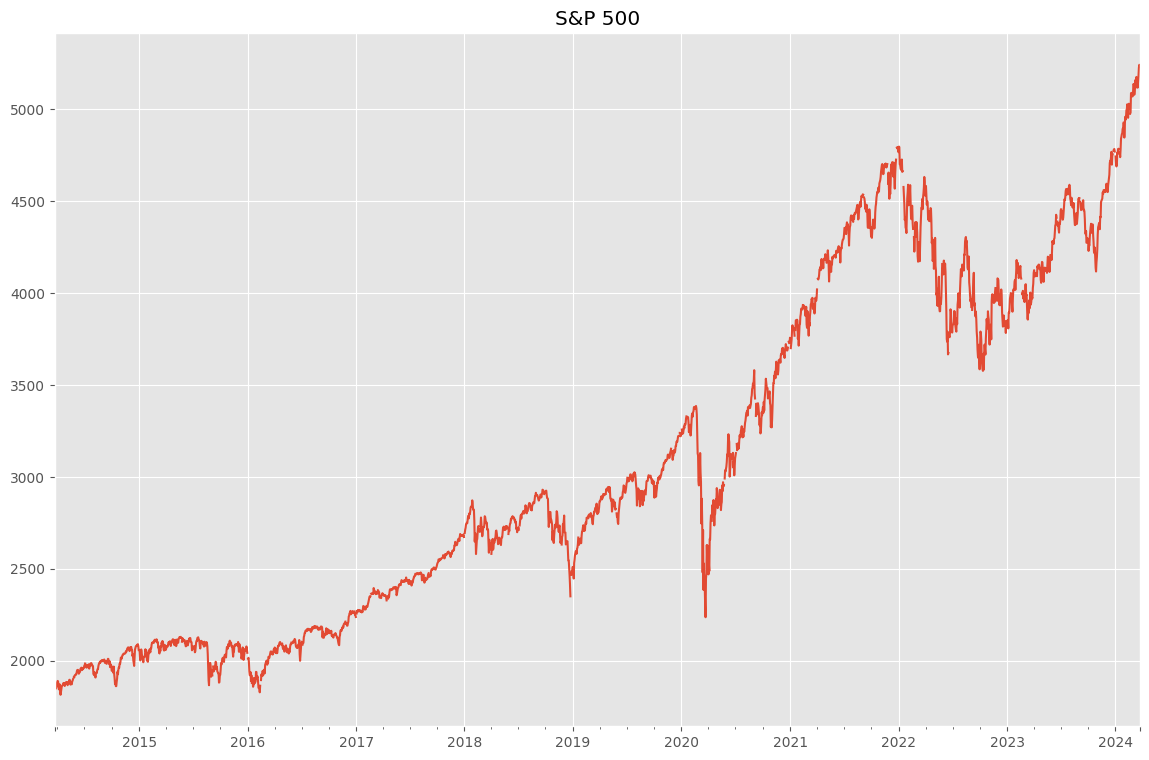

In [40]:
fred_Dset = fred.search('S&P', order_by = 'popularity')
sp500 = fred.get_series(series_id = "SP500")
sp500.plot(figsize=(14,9), title = "S&P 500" )

In [41]:
unemployemnt = fred.search("unemployment")

In [42]:
un_rate = fred.get_series("UNRATE")
unemployment_df=fred.search("unemployment rate state", filter=("frequency", "Monthly"))
unemployment_df=unemployment_df.query('units=="Percent" and seasonal_adjustment=="Seasonally Adjusted"')
unemployment_df = unemployment_df.loc[unemployment_df["title"].str.contains("Unemployment Rate")]

# 3->> Pulling Data !!

In [43]:
fred_CPI = fred.search("Inflation, consumer prices for the United States")
fred_CPI = fred_CPI.query('title=="Consumer Price Index for All Urban Consumers: Medical Care in U.S. City Average" and seasonal_adjustment=="Seasonally Adjusted"')
fred_CPI = fred.get_series("CPIMEDSL")
fred_CPI.name = "values"
fred_CPI.to_frame().reset_index()
fred_CPI = fred_CPI[fred_CPI.index > "1989-01-01"]

## Plotting 📈 the CPI from 1989-2023

In [44]:
fred_CPI.to_frame().reset_index()
CPI_plot = px.line(fred_CPI, x=fred_CPI.index, y="values", title="CPI AVG 1989-2024")
CPI_plot.show()

In [45]:
gg = fred_CPI.copy()
gg = pd.DataFrame(gg).reset_index()

In [46]:
gg = gg.rename(columns={"values": "y", "index": "ds"})
gg.tail()

,ds,y
416,2023-10-01,549.491
417,2023-11-01,552.182
418,2023-12-01,554.295
419,2024-01-01,556.811
420,2024-02-01,556.668


In [47]:
from prophet import Prophet

kkopp= Prophet()
kkopp.fit(gg)

03:30:53 - cmdstanpy - INFO - Chain [1] start processing
03:30:53 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
future = kkopp.make_future_dataframe(periods=10, freq="MS")


In [49]:
result  = kkopp.predict(future)
result[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,1989-02-01,144.099180,141.217143,146.951582
1,1989-03-01,145.562741,142.534422,148.508834
2,1989-04-01,146.590257,143.617853,149.597716
3,1989-05-01,147.543791,144.849971,150.455839
4,1989-06-01,148.729189,145.749051,151.675908
...,...,...,...,...
426,2024-08-01,568.260379,565.601680,571.205253
427,2024-09-01,569.352382,566.491410,572.311622
428,2024-10-01,570.199679,567.292379,573.169134
429,2024-11-01,571.167313,568.358581,574.184893


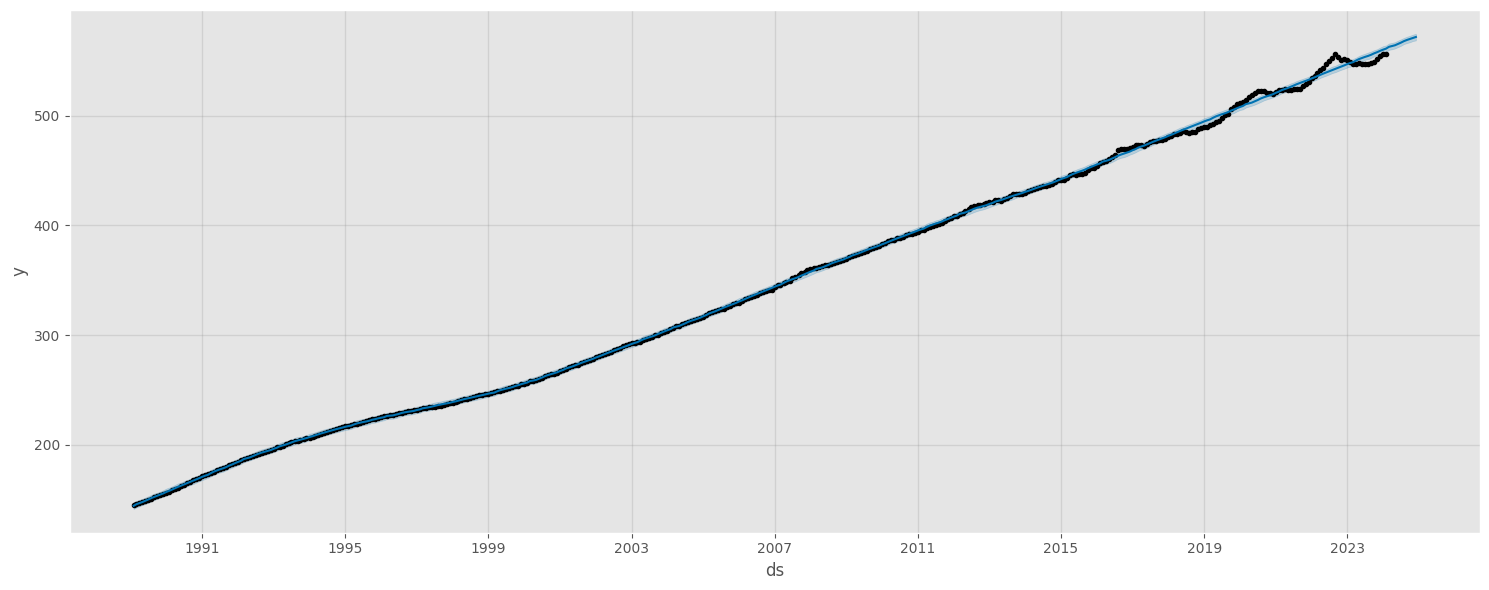

In [50]:
figure_prophet = kkopp.plot(result, figsize=(15, 6))

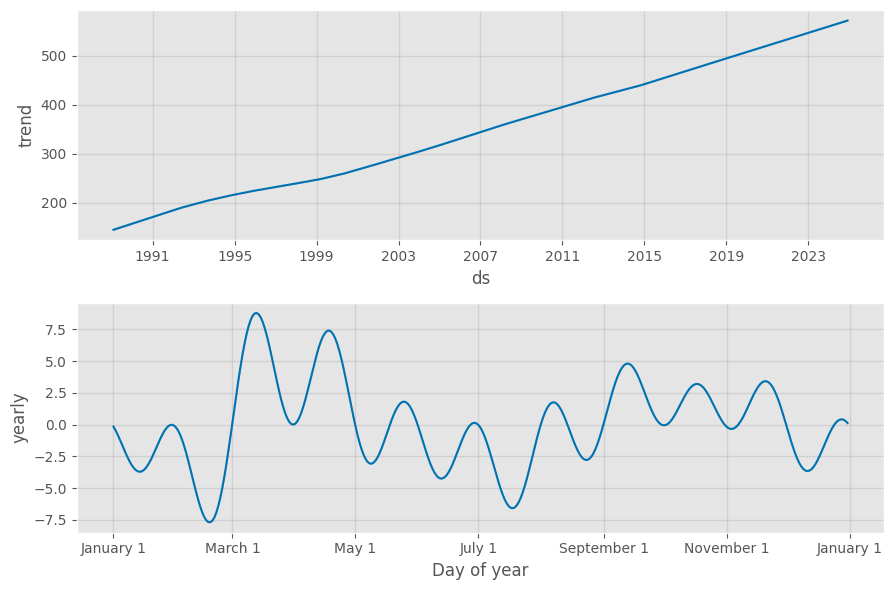

In [51]:
figure_porphet_2  = kkopp.plot_components(result)

In [52]:
from prophet.diagnostics import cross_validation,performance_metrics

gg_result = cross_validation(model=kkopp, initial=pd.to_timedelta(30*20, unit="D"), period=pd.to_timedelta(30*5, unit="D"), horizon=pd.to_timedelta(30*12, unit="D") )


df_p = performance_metrics(gg_result)

  0%|          | 0/79 [00:00<?, ?it/s]

03:30:55 - cmdstanpy - INFO - Chain [1] start processing
03:31:12 - cmdstanpy - INFO - Chain [1] done processing
03:31:13 - cmdstanpy - INFO - Chain [1] start processing
03:31:35 - cmdstanpy - INFO - Chain [1] done processing
03:31:35 - cmdstanpy - INFO - Chain [1] start processing
03:32:01 - cmdstanpy - INFO - Chain [1] done processing
03:32:01 - cmdstanpy - INFO - Chain [1] start processing
03:32:02 - cmdstanpy - INFO - Chain [1] done processing
03:32:02 - cmdstanpy - INFO - Chain [1] start processing
03:32:32 - cmdstanpy - INFO - Chain [1] done processing
03:32:32 - cmdstanpy - INFO - Chain [1] start processing
03:32:33 - cmdstanpy - INFO - Chain [1] done processing
03:32:33 - cmdstanpy - INFO - Chain [1] start processing
03:32:34 - cmdstanpy - INFO - Chain [1] done processing
03:32:34 - cmdstanpy - INFO - Chain [1] start processing
03:32:34 - cmdstanpy - INFO - Chain [1] done processing
03:32:35 - cmdstanpy - INFO - Chain [1] start processing
03:32:35 - cmdstanpy - INFO - Chain [1]

In [53]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,5.103823,2.259164,1.534579,0.004006,0.002803,0.004012,0.161290
1,37 days,5.612764,2.369127,1.586307,0.004107,0.002803,0.004114,0.172043
2,38 days,5.624809,2.371668,1.589800,0.004161,0.002803,0.004167,0.172043
3,39 days,6.537843,2.556921,1.688508,0.004350,0.002824,0.004358,0.172043
4,40 days,6.520763,2.553578,1.681618,0.004342,0.002824,0.004350,0.161290
...,...,...,...,...,...,...,...,...
320,356 days,12.125946,3.482233,2.647592,0.007138,0.006954,0.007144,0.311828
321,357 days,12.322254,3.510307,2.641176,0.007105,0.006954,0.007108,0.322581
322,358 days,12.182880,3.490398,2.609890,0.007012,0.006951,0.007015,0.330645
323,359 days,12.007399,3.465169,2.579126,0.006910,0.006951,0.006913,0.336022


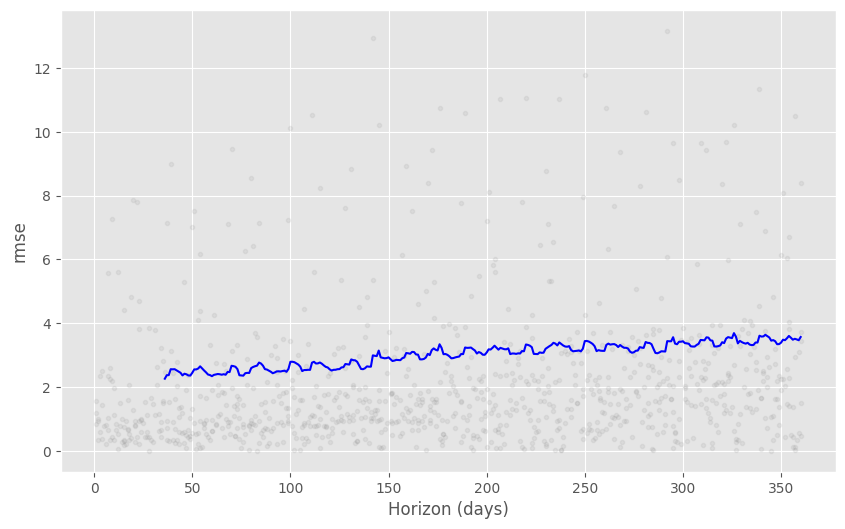

In [54]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(gg_result, metric='rmse')
